In [65]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
# Loading the dataset
data = pd.read_excel('Transaction Data.xlsx')

df = pd.DataFrame(data)

In [67]:
# Converting date columns to datetime
df['Transaction Date and Time'] = pd.to_datetime(df['Transaction Date and Time'])
df['Previous Transaction Date And Time'] = pd.to_datetime(df['Previous Transaction Date And Time'])

In [68]:
# Separating dates and times
df['Transaction Date'] = df['Transaction Date and Time'].dt.date
df['Transaction Time'] = df['Transaction Date and Time'].dt.time
df['Previous Transaction Date'] = df['Previous Transaction Date And Time'].dt.date
df['Previous Transaction Time'] = df['Previous Transaction Date And Time'].dt.time

In [69]:
# Rule-based flags
df['flag_ip'] = df.groupby(['IP Address', 'Transaction Amount'])['Transaction ID'].transform('count') > 3
df['flag_account'] = df.groupby(['Account ID', 'Merchant ID'])['Transaction ID'].transform('count') > 5

# Calculating time differences in seconds and flag transactions
df['Transaction Time'] = pd.to_datetime(df['Transaction Time'], format='%H:%M:%S').dt.time
df['Previous Transaction Time'] = pd.to_datetime(df['Previous Transaction Time'], format='%H:%M:%S').dt.time
df['flag_time'] = df.groupby('Account ID')['Transaction Time'].ltransform(lambda x: (pd.to_datetime(x.max(), format='%H:%M:%S') - pd.to_datetime(x.min(), format='%H:%M:%S')).seconds) < 60

# Flag transactions with outrageous amount differences
df['flag_amount_diff'] = abs(df['Transaction Amount'] - df['Transaction Amount'].shift(1)) > 1000

In [70]:
# Combinning flags
df['suspicious'] = df[['flag_ip', 'flag_account', 'flag_time', 'flag_amount_diff']].any(axis=1).astype(int)

In [57]:
# Preparing the data for modelling
X = df[['Transaction Amount', 'Number of Transactions', 'Login Attempts', 'Account Balance']]
y = df['suspicious']

In [58]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
# Isolation Forest for anomaly detection
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_train)

IsolationForest(contamination=0.1, random_state=42)

In [60]:
# Predicting on test data
y_pred = model.predict(X_test)
y_pred = [1 if x == -1 else 0 for x in y_pred]  # Convert -1 to 1 (anomaly) and 1 to 0 (normal)

Confusion Matrix:
[[666  55]
 [ 22  11]]


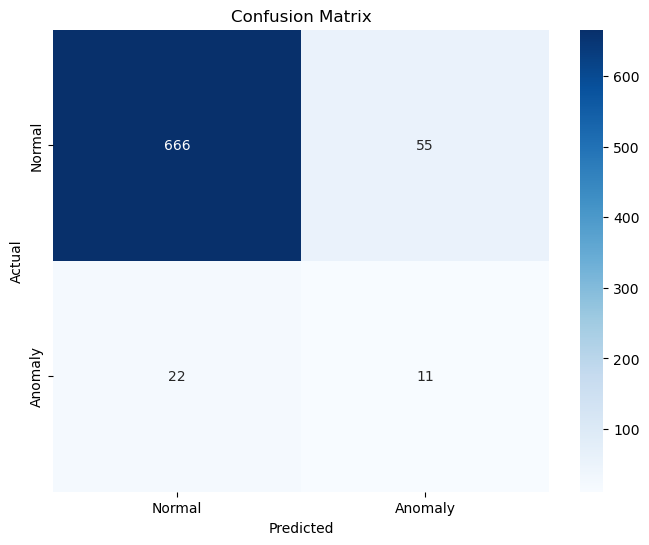

In [61]:
# Generating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [62]:
# Generate classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       721
           1       0.17      0.33      0.22        33

    accuracy                           0.90       754
   macro avg       0.57      0.63      0.58       754
weighted avg       0.93      0.90      0.91       754



In [64]:
# Saving flagged transactions
suspicious_transactions = df[df['suspicious'] == 1]
suspicious_transactions.to_csv('suspicious_transactions.csv', index=False)